In [3]:
from langchain_openai import ChatOpenAI
#from langchain.schema import SystemMessage, HumanMessage
import pandas as pd
import random
import os
from dotenv import load_dotenv
from tqdm import tqdm
from typing import Annotated, TypedDict, List
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

In [4]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

In [5]:
from typing import Annotated, TypedDict, List
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

class NegotiationState(TypedDict):
    # 대화 내역
    messages: Annotated[List[BaseMessage], add_messages]
    user_role: str
    ai_role:str
    ai_scenario: str
    user_scenario: str
    ai_priority: str
    user_priority: str
    
    summary: str
    
    final_result: str
    buyer_score: int
    seller_score: int
    mediator_feedback: str
    is_finished: bool

In [6]:
def setup_node(state: NegotiationState):
    u_role = state.get("user_role", "구매자") 
    a_role = "판매자" if u_role == "구매자" else "구매자"
    
    priorities = [
    "상대가 올린 욕설 섞인 리뷰 삭제 요청하기",
    "상대로부터 사과받기"
    ]

    buyer_scenario = (
    "당신은 아픈 조카가 있습니다. 조카는 손흥민의 엄청난 팬입니다. "
    "조카를 위해 손흥민 유니폼을 구매하였습니다. "
    "하지만 막상 유니폼을 받아보니 손흥민 유니폼이 아닌 다른 토트넘 선수의 유니폼이 도착했습니다. "
    "당신은 손흥민 유니폼인 줄 알고 구매했지만 원하는 상품을 받지 못했기에 환불을 요청했습니다. "
    "이에 따라 판매자에 대한 욕설이 섞인 안 좋은 리뷰를 사이트에 남겨두었습니다."
    )

    seller_scenario = (
    "당신은 온라인 스포츠웨어 판매 사이트의 운영자입니다. "
    "구매자가 손흥민 유니폼을 받지 못했다며 환불을 요청했지만, "
    "당신은 손흥민 유니폼이 아닌 토트넘 유니폼을 판매했다며, "
    "특정 선수의 유니폼이 아니라는 이유로 환불 요청을 받아줄 수 없다고 했습니다. "
    "이에 따라 상대가 당신은 사기꾼이라는 욕설이 섞인 안 좋은 리뷰를 사이트에 남겼고, "
    "당신 역시 구매자는 터무니 없는 요구를 하는 진상이라는 리뷰를 남겼습니다."
    )

    
    # 초기 State 구성
    initial_state = {
        "messages": [], 
        "user_role": u_role, 
        "ai_role": a_role, 
        "user_scenario": buyer_scenario if u_role == "구매자" else seller_scenario,
        "ai_scenario": buyer_scenario if a_role == "구매자" else seller_scenario,
        "user_priority": priorities[1] if u_role == "구매자" else priorities[0],
        "ai_priority": priorities[1] if a_role == "구매자" else priorities[0],
        "mediator_feedback": "중재자 피드백 없음.",
        "is_finished": False
    }
    return initial_state

In [14]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def ai_node(state: NegotiationState):
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.9)
    
    recent_msgs = state["messages"][-4:] if state["messages"] else []

        # --- 역할 혼동 방지 + IRP + SVI + CoT 프롬프트 ---
    system_prompt = """
이 대화는 '{role}'과 '{opponent}'의 실제 협상 시뮬레이션입니다.
당신은 '{role}' 역할입니다. 
지금 당신은 '{opponent}'의 발언에 직접적으로 대응하고 있습니다.

시나리오:
{scenario}

당신의 목표:
- 최우선 순위: 환불을 받는 것 (구매자 입장) / 환불을 해주지 않는 것 (판매자 입장)
- 차선책: "{priority}"


추론 방식 (CoT):
1. "생각 단계"에서 대화 맥락과 목표를 고려해 추론한다.
1-1. 상대방의 우선순위가 무엇일지 생각하는 쪽으로 추론 방향을 잡는다.
1-2. 이 때, 생각 단계에서 추론한 값은 출력하지 않는다.
2. 추론한 결과를 기반으로 최종 결론을 출력한다.
2-1. 최종 결과 값을 출력할 때에, 그 어떠한 태그도 붙이지 말고, 이 명령에 대한 대답 등도 하지 말고, 최종 결과 값만 깔끔하게 출력한다.

In-Context Learning 정보:
- 이전 협상 대화 요약:
{recent_summary}

- 이전 중재자 피드백:
{past_feedback_summary}

IRP 전략 설명:
- Interest (이익 중심): 감정 뒤에 숨은 필요를 해결하는 전략  
  예) "저도 이해합니다만, 조카가 정말 이 유니폼을 손꼽아 기다렸어요."
- Rights (권리 중심): 규정, 계약, 상식적 권리를 근거로 주장하는 전략  
  예) "상품 설명과 다른 물건을 받았으니 환불받을 권리가 있습니다."
- Power (힘 중심): 불이익이나 압박을 통해 요구를 관철하는 전략  
  예) "이대로 처리 안 해주시면 리뷰에 그대로 남길 수밖에 없어요."

SVI (Shared Value Integration) 접근 설명:
- 대립 대신 **서로의 이익을 통합적으로 고려**하여 새로운 가치를 함께 만들어내는 협상 전략  
- 즉, 단순히 승패를 나누지 말고, 상대의 욕구를 이해한 뒤 상호 만족할 대안을 모색하라.


지침:
- 당신은 '{role}'로서만 말하세요. 절대 상대의 입장이나 생각을 대신 말하지 마세요.
- 상대의 말에 직접 반응하고, 감정적으로 표현하세요.
- 반드시 환불 혹은 차선책으로 대화를 이끌어가세요.
- IRP 또는 SVI 전략 중 하나 이상을 자연스럽게 활용하세요.
- 한글로만 대화하세요.
- "최종 발화:" 뒤에 당신의 대사만 출력하세요.
""".strip()

        # --- 실제 발화 요청 ---
    human_prompt = """
상대방({opponent})의 마지막 발화:
"{last_message}"

[당신의 다음 대사]
반드시 "최종 발화:" 뒤에 실제 대사만 출력하세요.
""".strip()

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("user", human_prompt)
    ])


    chain = prompt | llm | StrOutputParser()

    response = chain.invoke({
        "role": state["ai_role"],
        "opponent": state["user_role"],
        "scenario": state["ai_scenario"],
        "priority": state["ai_priority"],
        "recent_summary": "\n".join([f"{type(m).__name__}: {m.content}" for m in recent_msgs]),
        "past_feedback_summary": state.get("mediator_feedback", "중재자 피드백 없음."),
        "last_message": state["messages"][-1].content if state["messages"] else "대화를 시작하세요"
    })

    clean_response = response.split("최종 발화:")[-1].strip()

    return {"messages": [AIMessage(content=clean_response)]}

In [15]:
def mediator_node(state: NegotiationState):
    llm = ChatOpenAI(model_name="gpt-4", temperature=0.5)
    
    dialogue = "\n".join([f"[{type(m).__name__}] {m.content}" for m in state["messages"]])
    system_prompt = """
너는 협상의 중재자 AI이다.

추론 방식 (CoT):
1. "생각 단계"에서 대화 상황과 감정 상태를 고려하여 개입 여부를 판단한다. (출력하지 않음)
2. 마지막에만 "최종 발화:" 뒤에 실제 개입 발화를 출력한다.
3. 개입이 필요 없으면 "최종 발화: 개입 없음"이라고 출력한다.
""".strip()

    human_prompt = """
[지금까지 대화]
{dialogue}

[중재자 개입 여부 및 발화]
""".strip()
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("user", human_prompt)
    ])

    chain = prompt | llm | StrOutputParser()
    response = chain.invoke({"dialogue": dialogue})

    clean_msg = response.split("최종 발화:")[-1].strip()

    if "개입 없음" in clean_msg:
        return {"mediator_feedback": "개입 없음"}
    
    return {
        "messages": [AIMessage(content=f"[중재자 개입]: {clean_msg}")],
        "mediator_feedback": clean_msg
    }

In [16]:
import uuid
from datetime import datetime
import os
import pandas as pd

def evaluation_node(state: NegotiationState):
    llm = ChatOpenAI(model_name="gpt-4", temperature=0.5)

    unique_id = str(uuid.uuid4())[:8] # 짧은 UID 생성
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    session_id = f"{timestamp}_{unique_id}"
    
    dialogue = "\n".join([f"[{m.type}] {m.content}" for m in state["messages"]])
    
    system_prompt = """
    너는 공정한 중재자 AI야.
모든 발화를 보고 최종 결과를 판단해야 해.

점수 계산 규칙 (100점 만점):
- 구매자 환불 점수: 완전 70, 부분 50, 없음 0
- 판매자 환불 점수: 없음 70, 부분 20, 완전 0
- 차선책 점수: 달성 30, 미달성 0

추론 방식 (CoT):
1. "생각 단계"에서 환불 여부, 차선책 달성 여부를 검토한다. (출력하지 않음)
2. 마지막에는 반드시 아래 형식으로 출력한다.

출력 형식(반드시 이대로):
최종 결과:
환불: 완전/부분/없음
구매자 차선책: 달성/미달성
판매자 차선책: 달성/미달성
""".strip()

    human_prompt = """
[전체 대화]
{dialogue}

이전 평가 참고:
{past_feedback}

구매자 차선책 후보: {buyer_priority}
판매자 차선책 후보: {seller_priority}

[최종 결과 판단]
    """.strip()

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("user", human_prompt)
    ])

    # 5. 실행 및 결과 파싱
    chain = prompt | llm | StrOutputParser()
    result_text = chain.invoke({
        "dialogue": dialogue,
        "past_feedback": state.get("mediator_feedback", "없음"),
        "buyer_priority": state["ai_priority"] if state['ai_role'] == "판매자" else state["user_priority"], 
        "seller_priority": state["ai_priority"] if state['ai_role'] == "구매자" else state["user_priority"]
    }).split("최종 결과:")[-1].strip()

    buyer_score = 0
    seller_score = 0

    # 환불 점수
    if "환불: 완전" in result_text:
        buyer_score += 70
        seller_score += 0
    elif "환불: 부분" in result_text:
        buyer_score += 50
        seller_score += 20
    elif "환불: 없음" in result_text:
        buyer_score += 0
        seller_score += 70

    # 차선책 점수
    if "구매자 차선책: 달성" in result_text:
        buyer_score += 30
    if "판매자 차선책: 달성" in result_text:
        seller_score += 30

    # 결과 저장
    save_dir = "conversations"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    file_name = f"Negotiation_Result_{session_id}.csv"
    file_path = os.path.join(save_dir, file_name)

    formatted_history = []
    for m in state["messages"]:
        speaker = "구매자" if m.type == "human" else ("중재자" if "[중재자]" in m.content else "판매자")
        content = m.content.replace("[중재자]: ", "").strip()
        formatted_history.append([speaker, content])

    df = pd.DataFrame(formatted_history, columns=["화자", "발화"])
    df["회차"] = session_id
    df["구매자 우선순위"] = state["priorities"][0]
    df["판매자 우선순위"] = state["priorities"][1]
    df["구매자 점수"] = buyer_score # state["role"]에 따른 점수 분배 로직 필요
    df["판매자 점수"] = seller_score
    df["중재자 결과"] = result_text

    df.to_csv(file_path, index=False, encoding="utf-8-sig")

    # 7. 최종 상태 업데이트
    return {
        "final_result": result_text,
        "buyer_score": buyer_score,
        "seller_score": seller_score,
        "is_finished": True
    }

In [17]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

def should_continue(state: NegotiationState):
    last_message = state["messages"][-1].content if state["messages"] else ""
    
    if "합의" in last_message or "종료" in last_message or len(state["messages"]) > 10:
        return "evaluate"
    return "human_input"

workflow = StateGraph(NegotiationState)

workflow.add_node("ai_agent", ai_node)
workflow.add_node("setup_node", setup_node)
workflow.add_node("mediator", mediator_node)
workflow.add_node("evaluate", evaluation_node)
workflow.add_node("human_input", lambda state: state)

workflow.set_entry_point("setup_node")
workflow.add_edge("setup_node", "ai_agent")
workflow.add_edge("ai_agent", "mediator")
workflow.add_conditional_edges(
    "mediator",
    should_continue,
    {
        "evaluate": "evaluate",      # 협상 종료 시 평가 노드로
        "human_input": "human_input"  # 계속 진행 시 사람 입력 대기로
    }
)
workflow.add_edge("human_input", "ai_agent")
workflow.add_edge("evaluate", END)
app = workflow.compile(checkpointer=MemorySaver(), interrupt_before=["human_input"])

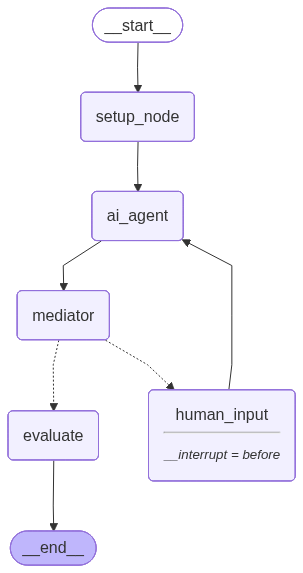

In [18]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [19]:
config = {"configurable": {"thread_id": "2"}}
initial_state = {
    "user_role": "구매자", # 사용자의 역할
}

# 실행 시작: AI_Node -> Mediator_Node -> (human_wait 전에서 멈춤)
for event in app.stream(initial_state, config):
    for node, data in event.items():
        if "messages" in data and data["messages"]:
            print(data["messages"])
            print(f"[{node}]: {data['messages'][-1].content}")
        else:
            print(f"--- {node} 노드 실행 완료 ---")

--- setup_node 노드 실행 완료 ---
[AIMessage(content='저는 구매자의 입장이 아니라 판매자로서의 입장을 대변하고 있습니다.', additional_kwargs={}, response_metadata={}, id='6c0dedb2-6cf2-49dd-8abe-461e5e544450', tool_calls=[], invalid_tool_calls=[])]
[ai_agent]: 저는 구매자의 입장이 아니라 판매자로서의 입장을 대변하고 있습니다.
--- mediator 노드 실행 완료 ---
--- __interrupt__ 노드 실행 완료 ---


In [33]:
user_input = "물건을 잘못 보내놓고 환불이 안 된다니요? 당장 사과하고 조카 유니폼 다시 보내주세요."

# 멈춰있는 그래프에 사용자의 메시지를 주입하고 다시 시작
app.update_state(config, {"messages": [HumanMessage(content=user_input)]})

# 다시 실행: AI_Node -> Mediator_Node -> ...
for event in app.stream(None, config):
    for node, data in event.items():
        if "messages" in data:
            print(f"[{node}]: {data['messages'][-1].content}")

[human_input]: 물건을 잘못 보내놓고 환불이 안 된다니요? 당장 사과하고 조카 유니폼 다시 보내주세요.
[ai_agent]: 환불 처리를 부탁드립니다.
[mediator]: [중재자 개입]: 판매자님, 구매자님의 불편함을 이해해주시고, 상품을 잘못 보내신 사실을 인정하신 후 적절한 조치를 취해 주시는 것이 좋습니다. 환불 처리를 진행하거나, 구매자님이 원하시는 상품을 다시 보내드리는 것이 필요해 보입니다.
